<a href="https://colab.research.google.com/github/rogerlga/mvp-mla/blob/main/mvp_mla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Machine Learning & Analytics

**Autor:** Roger Luis Giroldo Assunção

**Data:** 28/09/2025

**Matrícula:** 4052025000584

**Dataset:** Dados operacionais de Turbogerador - Adendo A.3 da oportunidade nº 7004066211 do [Portal Petronect](https://www.petronect.com.br/irj/go/km/docs/pccshrcontent/Site%20Content%20(Legacy)/Portal2018/pt/lista_licitacoes_concluidas.html)

# **Descrição do problema**

## Dataset

Iremos trabalhar com dados de uma operação industrial. Faremos uso de dados disponibilizados publicamente em um processo de licitação da Petrobras, acessível em:

> [Portal Petronect](https://www.petronect.com.br/irj/go/km/docs/pccshrcontent/Site%20Content%20(Legacy)/Portal2018/pt/lista_licitacoes_concluidas.html)<br>
> Nº da oportunidade = 7004066211

Dentre os datasets disponibilizados, analisaremos o dataset do "Adendo A.3", referente a um trem de equipamentos para geração de energia: um turbogerador composto por turbina a gás, caixa de engrenagem e gerador elétrico.

## Descrição

Este trabalho é uma continuação do trabalho de Análise de Dados e Boas Práticas (https://github.com/rogerlga/mvp-adbp). Reproduziremos uma breve descrição do contexto e do problema, para depois prosseguir com a modelagem de Machine Learning.

Nesse estudo focaremos na modelagem não supervisionada de agrupamento (clusterização).

O esquema abaixo representa o trem de equipamentos objeto da análise, formado por:

- Turbina a Gás - composta pelo GG (Gas Generator) e a PT (Power Turbine),
- Caixa de Engrenagem (Gearbox), e
- Gerador Elétrico (Generator).

<img src="https://raw.githubusercontent.com/rogerlga/mvp-adbp/refs/heads/main/assets/two_shaft_turbogenerator.jpg" width="800">

*Figura 1 - Trem de equipamentos (fonte: http://emadrlc.blogspot.com/2013/01/chapter-1-introduction-to-gas-turbines.html)*

As variáveis ou atributos do dataset são medições de instrumentos/sensores instalados nesses equipamentos. A essas variáveis nos referimos por "tags".

O presente estudo irá abordar a Turbina a Gás, delimitada no desenho pelo "Gas Generator" (GG) e pela "Power Turbine" (PT).

### Turbina a Gás

Os instrumentos da Turbina a Gás são descritos a seguir (as referências numéricas encontram-se na próxima figura):

1. Abertura da válvula de controle, pressões e temperatura do gás combustível;
2. Pressões e temperatura do combustível líquido (diesel);
3. Pressão e temperatura na sucção do compressor;
4. Pressão e posições de VSVs (Variable Stator Vanes) do compressor;
5. Vibração do GG;
6. Pressão e temperatura na descarga do compressor;
7. Pressão e temperatura na exaustão do GG;
8. Temperatura do ar de refrigeração da PT;
9. Vibração da PT;
10. Temperatura na exaustão da PT;
11. Temperatura do óleo no sump A;
12. Pressões e temperaturas na AGB (Accessory GearBox);
13. Temperatura do óleo no sump B;
14. Pressões do ar de refrigeração do GG;
15. Temperatura do óleo no sump C;
16. Temperaturas do 2º estágio da PT;
17. Posição axial da PT;
18. Temperaturas do mancal axial da PT;
19. Temperatura do ar na saída do compartimento da turbina.

A figura a seguir apresenta a localização na Turbina a Gás dos instrumentos do dataset em análise, agrupados conforme numeração acima:

<img src="https://raw.githubusercontent.com/rogerlga/mvp-adbp/refs/heads/main/assets/TG_tags.png" width="900">

*Figura 2 - Representação de uma Turbina a Gás com os atributos do dataset (fonte: adaptado de https://www.researchgate.net/figure/Schematic-of-LM2500-marine-gas-turbine_fig1_349497740 pelo autor)*

No trabalho anterior fizemos a análise exploratória desses dados e os pré-processamos, de forma a eliminar redundâncias e enriquecer os dados com feature engineering.

## Hipóteses

As hipóteses referentes ao problema, e que o trabalho anterior evidenciou serem verdadeiras, são:

- Existe correlação entre as variáveis, de forma que futuramente poderemos predizer um atributo target a partir dos demais;
- Não há dados anômalos suficientes na indústria, o que dificulta treinos supervisionados para detecção de anomalias;
- É possível distinguir diferentes perfis operacionais através dos dados, visando futuramente treinar um modelo que faça a clusterização automática desses perfis.

## Objetivos

O objetivo desse estudo irá focar na última hipótese:

- Treinar um modelo **nâo supervisionado** para **agrupamento/clusterização** automática dos distintos perfis operacionais. Exemplos de perfis operacinais são combinações entre: operação com gás, operação com diesel, turbina em carga base, em carga parcial, etc. O objetivo é agrupar os distintos perfis, mas sem atribuição dos rótulos, visto que o aprendizado será não supervisionado. A idéia é que, a partir dos grupos (labels) que o algoritmo identificar, seja facilitada a tarefa de identificação e rotulação dos perfis pelo usuário com a expertise de domínio. Isso ajudará, por exemplo, na implementação de outros modelos, como detecção de anomalias, onde é importante o balanceamento dos dados com relação aos perfis operacionais.

# **Ambiente e Reprodutibilidade**

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

# Semente para reprodutibilidade
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Classes e funções utilitárias

> Obs: para descrição individual, ver docstrings abaixo.

In [2]:
class SingleSplitCV:
    """CV customizado para clustering: split único, com treino e teste iguais, abrangendo todos os dados."""

    def split(self, X, y=None, groups=None):
        indices = np.arange(len(X))
        yield indices, indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        return 1

def scorer(estimator, X, y=None):
    """Scorer com validações para uso de grid search em problemas de clusterização."""
    try:
        # Transforma os dados e obtém os rótulos previstos
        X_transformed = estimator[:-1].transform(X)
        try: labels = estimator[-1].labels_
        except: labels = estimator[-1].predict(X_transformed)
        
        # Verifica se há pelo menos 2 clusters
        if len(np.unique(labels)) < 2:
            return -1
        
        return silhouette_score(X_transformed, labels)
    
    except Exception as e:
        print(f"Erro no scoring: {e}")
        return -1
    
def print_tabulate(data, headers=None, showindex=None, tablefmt="simple_outline", **kwargs):
    """Wrapper para formatação de dataframes, series e arrays com tabulate"""
    if isinstance(data, pd.Series):
        data = data.to_frame()
    if isinstance(data, dict):
        data = pd.DataFrame.from_dict(data, orient="index")
        if headers is None: headers = ()

    if isinstance(data, pd.DataFrame):
        values = data.values
        if headers is None: headers = data.columns.to_list()
        if showindex is None or showindex is True: showindex = data.index.to_list()
    # elif isinstance(data, dict):
    #     values = [data.values()]
    #     if headers is None: headers = ()
    #     if showindex is None or showindex is True: showindex = list(data.keys())
    else:
        values = data
        if headers is None: headers = ()
        if showindex is None: showindex = "default"

    print(tabulate(values, headers=headers, showindex=showindex, tablefmt=tablefmt, **kwargs))

# **Dados**

## Carregamento

In [3]:
df_orig = pd.read_csv("https://raw.githubusercontent.com/rogerlga/mvp-adbp/refs/heads/main/Adendo%20A.3_Conjunto%20de%20Dados_DataSet.csv")
display(df_orig)

,role,offset_seconds,FCV-501D_ACT,PIT-501D,PIT-516D,PIT-517D,PIT-518D,PIT-519D,PIT-521D,PIT-523D,...,XT-506D-Y,XT-507D-X,XT-507D-Y,XT-508D-X,XT-508D-Y,ZT-502D-B,ZT-503D-A,ZT-503D-B,ZT-504D-B,ZY-503D
0,normal,0,0.093365,39.415924,41.075237,14.206766,1.830773,2.020237,0.993242,3.089954,...,13.767499,8.439675,9.485600,6.249623,9.437153,0,30.459438,31.059893,0.021454,30.506254
1,normal,600,44.311640,40.794920,20.016014,16.595196,1.910074,2.102871,0.993093,3.212281,...,13.392683,8.305780,9.398658,6.260321,9.759181,0,28.230920,29.049870,0.020295,28.474077
2,normal,1200,44.798360,40.914326,20.403154,16.904266,1.952567,2.144405,0.992827,3.255982,...,12.717816,8.284384,9.145153,6.503127,9.858340,0,27.489810,28.231247,0.027651,27.643566
3,normal,1800,40.826504,41.118400,17.996868,15.036872,1.724176,1.896201,0.994433,2.974362,...,12.586370,8.439492,9.912035,7.257236,10.600057,0,31.836023,32.614727,0.021270,31.978290
4,normal,2400,41.870740,40.940940,18.591139,15.483633,1.795136,1.966321,0.993852,3.040638,...,11.869439,8.516968,9.650540,7.247705,10.561379,0,31.777662,32.095505,0.023787,31.724266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23306,test-1,5527200,0.085501,6.386002,-0.163931,-0.424249,-0.003189,0.001584,1.008135,1.009791,...,0.713555,0.775147,0.581360,0.733273,0.581360,0,96.111910,100.178131,0.125521,97.705260
23307,test-1,5527800,0.086756,6.386612,-0.165947,-0.424149,-0.003019,0.002137,1.007647,1.009126,...,0.678254,0.733362,0.581360,0.810270,0.581360,0,96.144750,100.193535,0.127659,97.705260
23308,test-1,5528400,0.086408,6.390349,-0.158468,-0.413925,-0.002763,0.001464,1.007344,1.008680,...,0.684826,0.768575,0.574788,0.768575,0.623235,0,96.129130,100.206207,0.128289,97.705260
23309,test-1,5529000,0.085385,6.389178,-0.163140,-0.411039,-0.003285,0.001545,1.006824,1.008357,...,0.713064,0.733518,0.581360,0.733518,0.629807,0,96.116104,100.184265,0.127998,97.705260


## Características básicas

In [4]:
print("ℹ️ Amostra do dataframe:")
print_tabulate(df_orig.sample(10))
print("\nℹ️ Dimensões do dataframe:", df_orig.shape)
print("\nℹ️ Tipos dos atributos e quantidade de nulos/inválidos:")
print_tabulate(pd.concat((df_orig.dtypes, df_orig.isna().sum()), axis=1), headers=["atributo", "tipo", "qtd nulos"])

ℹ️ Amostra do dataframe:
┌───────┬────────┬──────────────────┬────────────────┬─────────────┬────────────┬────────────┬─────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬─────────────┬───────────┬───────────┬───────────┬───────────┬───────────┬─────────────┬───────────┬───────────┬─────────────┬─────────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬─────────────┬─────────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┬───────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬───────

# **Análise e Preparação**

## Tratamento inicial

Conforme visto no estudo anterior, o role "test-0" é idêntico ao "normal", por isso será eliminado. Além disso, é aplicada uma reamostragem para que os dados fiquem consolidados a cada 1h, pois interessa mais o perfil operacional representativo das janelas horárias, do que a cada 10 minutos, como no dataset original.

In [5]:
df = df_orig[df_orig["role"] != "test-0"] # Elimina role "test-0"
df.index = pd.TimedeltaIndex(pd.to_timedelta(df["offset_seconds"], unit='s')) # Usa temporariamente o offset_seconds como índice temporal
df = df.groupby("role").resample("1h").last().dropna(ignore_index=True) # Reamostragem horária, mantendo última observação
df

,role,offset_seconds,FCV-501D_ACT,PIT-501D,PIT-516D,PIT-517D,PIT-518D,PIT-519D,PIT-521D,PIT-523D,...,XT-506D-Y,XT-507D-X,XT-507D-Y,XT-508D-X,XT-508D-Y,ZT-502D-B,ZT-503D-A,ZT-503D-B,ZT-504D-B,ZY-503D
0,normal,3000.0,41.106903,41.044296,18.115240,15.114297,1.736279,1.905550,0.994227,2.983607,...,12.334263,8.352473,9.776409,7.286647,10.416700,0.0,32.136173,32.596294,0.024578,32.214970
1,normal,6600.0,45.559010,40.685463,20.916270,17.349290,2.029217,2.215605,0.992370,3.335414,...,11.966332,8.468472,9.311462,6.976323,10.212553,0.0,26.535963,26.905193,0.061297,26.602022
2,normal,10200.0,47.116543,40.626442,21.869236,18.119350,2.124781,2.319191,0.991775,3.460335,...,11.878652,8.342441,9.146814,6.753309,9.941579,0.0,24.002470,24.779950,0.074429,24.078333
3,normal,13800.0,48.873295,40.555040,23.004726,19.024174,2.245536,2.450835,0.990484,3.601859,...,12.218514,8.342779,8.982535,6.637197,9.824729,0.0,21.785587,22.480484,0.074424,21.907177
4,normal,17400.0,50.200030,40.471085,23.695934,19.560738,2.312406,2.519565,0.989163,3.680950,...,12.296323,8.362313,8.885399,6.511511,9.670374,0.0,20.280977,21.090866,0.081264,20.455530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,test-1,5518200.0,0.084293,6.360807,-0.164717,-0.414108,-0.003138,0.001719,1.008647,1.009614,...,0.678254,0.775147,0.588131,0.775147,0.629807,0.0,96.122070,100.185806,0.124704,97.705260
2718,test-1,5521800.0,0.083197,6.372912,-0.169674,-0.424424,-0.002760,0.001483,1.009299,1.010670,...,0.726700,0.733241,0.581360,0.775147,0.629807,0.0,96.137190,100.186249,0.122827,97.705260
2719,test-1,5525400.0,0.092990,6.380492,-0.170590,-0.433163,-0.003048,0.001628,1.009016,1.010321,...,0.726700,0.768477,0.581360,0.810253,0.581360,0.0,96.135980,100.201576,0.121955,97.705260
2720,test-1,5529000.0,0.085385,6.389178,-0.163140,-0.411039,-0.003285,0.001545,1.006824,1.008357,...,0.713064,0.733518,0.581360,0.733518,0.629807,0.0,96.116104,100.184265,0.127998,97.705260


Em seguida, restringiremos o estudo às variáveis da Turbina a Gás:

In [6]:
df = df[[
    "role", "offset_seconds",
    "FCV-501D_ACT", "PIT-501D", "PIT-516D", "PIT-517D", "PIT-518D", "PIT-519D", "PIT-521D", "PIT-523D",
    "PIT-529D", "PIT-530D", "PIT-532D", "PT-502D", "PT-503D", "PT-525D", "TE-504D", "TE-506D",
    "TE-507D-A", "TE-508D", "TE-509D", "TE-514D-A", "TE-515D-A", "TE-516D", "TE-517D", "TE-521D",
    "TE-522D", "TE-523D", "TE-524D", "TE-525D", "TE-526D", "TIT-501D", "TIT-505D", "TIT-561D",
    "VT-501D", "VT-502D", "ZT-502D-B", "ZT-503D-A", "ZT-503D-B", "ZY-503D"
]].copy()

E aplicaremos o restante dos pré-processamentos de eliminação de redundâncias e feature engineering feitos no trabalho anterior e consolidados na célula abaixo:

> Obs: o termo "grupo" aqui se refere ao agrupamento de sensores apresentado na Figura 2 do início desse trabalho.

In [7]:
df.drop(columns="ZT-502D-B", inplace=True) # Variáveis com valores 0 apenas
df.drop(columns=["PIT-501D", "PT-502D"], inplace=True) # Pré-processamento das variáveis dos grupos de sensores 1 e 2
df.drop(columns=["ZT-503D-A", "ZT-503D-B"], inplace=True) # Pré-processamento das variáveis do grupo de sensores 4
df["PIT-518D_519D"] = df[["PIT-518D", "PIT-519D"]].mean(axis=1) # Pré-processamento das variáveis dos grupos de sensores 8, 14 e 16
df.drop(columns=["PIT-518D", "PIT-519D"], inplace=True) # ...continuação
df["PIT-529D_530D"] = df[["PIT-529D", "PIT-530D"]].mean(axis=1) # Pré-processamento das variáveis do grupo de sensores 12
df["TE-521D_522D"] = df[["TE-521D", "TE-522D"]].max(axis=1) # ...continuação
df.drop(columns=["PIT-529D", "PIT-530D", "TE-521D", "TE-522D"], inplace=True) # ...continuação

## Definição das Variáveis

Para construção da matriz X que será usada no treino e teste dos modelos, elimina-se o atributo de tempo, dado que ele não contribui para a definição de perfis operacionais do equipamento:

In [8]:
features = df.columns.drop(["offset_seconds"]).to_list()
X = df[features].copy()
print("ℹ️ Dimensões de X:", X.shape)

ℹ️ Dimensões de X: (2722, 31)


No problema de clusterização em questão, utilizaremos o mesmo conjunto de dados X tanto para treino quanto para teste, dispensando técnicas tradicionais como validação cruzada ou holdout, devido à natureza **não supervisionada** do problema. Diferentemente de algoritmos supervisionados, onde buscamos generalização para dados não vistos, o clustering tem como objetivo descobrir a **estrutura intrínseca** dos dados disponíveis, agrupando observações similares dentro do próprio dataset. A divisão dos dados comprometeria essa descoberta estrutural, pois reduziria artificialmente a informação disponível para identificar padrões naturais de agrupamento. Além disso, métricas como Silhouette Score, Calinski-Harabasz e Davies-Bouldin avaliam a **qualidade interna** dos clusters formados - coesão dentro dos grupos e separação entre grupos - utilizando as mesmas observações que geraram os clusters. Essa abordagem é metodologicamente adequada, pois o objetivo não é predizer labels de novos dados, mas sim **otimizar a partição** do conjunto de dados existente de forma a maximizar a homogeneidade intra-cluster e a heterogeneidade inter-cluster.

## Pipeline de pré-processamento (transformações)

Ainda seguindo o estudo anterior, colocaremos as operações de pré-processamento que envolvem transformações em um pipeline denominado "preprocessor".

In [9]:
# Identifica colunas numéricas e categóricas
numeric_cols = [c for c in X.columns if str(X[c].dtype).startswith(("float", "int"))]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Pré-processamento
preprocessor = ColumnTransformer([
    ("numeric", MinMaxScaler(), numeric_cols),
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
])

## Baseline, candidatos e avaliação rápida

Definimos o baseline utilizando um modelo bastante comum para clusterização (KMeans). Os candidatos também são típicos para esse tipo de problema, mas possuem um pouco mais de complexidade em relação ao baseline.

Após definição dos modelos baseline e candidatos, executamos uma avaliação rápida dos modelos para termos uma noção inicial do resultado.

Importante salientar que o **Silhouette Score** foi escolhido como métrica principal para avaliação dos modelos de clusterização por oferecer uma **interpretação intuitiva e balanceada** da qualidade dos clusters formados. Com valores normalizados entre -1 e 1, o Silhouette Score facilita a comparação entre diferentes configurações de parâmetros no GridSearchCV, onde valores próximos a 1 indicam clusters bem definidos, valores próximos a 0 sugerem sobreposição entre grupos, e valores negativos apontam para classificações incorretas. Diferentemente do **Calinski-Harabasz Index**, que tende a favorecer um número maior de clusters devido à sua natureza de razão de variâncias, e do **Davies-Bouldin Index**, que pode ser sensível à forma dos clusters e à presença de outliers, o Silhouette Score considera simultaneamente a **coesão intra-cluster** (distância média aos pontos do mesmo cluster) e a **separação inter-cluster** (distância ao cluster mais próximo), proporcionando uma avaliação mais robusta e equilibrada. Além disso, sua implementação é computacionalmente eficiente e amplamente suportada no ecossistema scikit-learn, tornando-se uma escolha pragmática para otimização automatizada de hiperparâmetros em pipelines de machine learning.

In [10]:
# Baseline e candidatos
models = {
    "KMeans": Pipeline([("pre", preprocessor), ("model", KMeans(n_clusters=4, random_state=SEED))]),
    "GaussianMixture": Pipeline([("pre", preprocessor), ("model", GaussianMixture(n_components=4, random_state=SEED))]),
    "DBSCAN": Pipeline([("pre", preprocessor), ("model", DBSCAN(min_samples=30))]),
    "HDBSCAN": Pipeline([("pre", preprocessor), ("model", HDBSCAN(min_samples=30))]),
}
baseline_name = "KMeans"
baseline = models[baseline_name] # KMeans como baseline
candidates = {k: v for k, v in models.items() if k != baseline_name} # Outros modelos como candidatos
print("ℹ️ Estrutura dos modelos para avaliação rápida (e.g. baseline):")
display(baseline)

# Avaliação rápida dos modelos
for i, (name, pipeline) in enumerate(models.items()):
    print("🟢 BASELINE:" if name == baseline_name else f"🔵 CANDIDATO {i}:", name)
    labels = pipeline.fit_predict(X)
    print("Silhouette Score:", scorer(pipeline, X))
    print("Labels:", pd.Series(labels).value_counts().to_dict())
    print()

ℹ️ Estrutura dos modelos para avaliação rápida (e.g. baseline):


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['FCV-501D_ACT', 'PIT-516D',
                                                   'PIT-517D', 'PIT-521D',
                                                   'PIT-523D', 'PIT-532D',
                                                   'PT-503D', 'PT-525D',
                                                   'TE-504D', 'TE-506D',
                                                   'TE-507D-A', 'TE-508D',
                                                   'TE-509D', 'TE-514D-A',
                                                   'TE-515D-A', 'TE-516D',
                                                   'TE-517D', 'TE-523D',
                                                   'TE-524D', 'TE-525D',
                                                   'TE-526D', 'TIT-501D',
                                                   'TIT-505D', 'TIT-561D',
                                                   'VT-501D', 'VT-502D',
                                                   'ZY-503D', 'PIT-518D_519D',
                                                   'PIT-529D_530D',
                                                   'TE-521D_522D']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['role'])])),
                ('model', KMeans(n_clusters=4, random_state=42))])

🟢 BASELINE: KMeans
Silhouette Score: 0.7209469936193981
Labels: {1: 1485, 0: 912, 2: 280, 3: 45}

🔵 CANDIDATO 1: GaussianMixture
Silhouette Score: 0.7131690303895276
Labels: {1: 1450, 0: 910, 2: 314, 3: 48}

🔵 CANDIDATO 2: DBSCAN
Silhouette Score: 0.7198407950853423
Labels: {2: 1447, 0: 910, 1: 268, -1: 66, 3: 31}

🔵 CANDIDATO 3: HDBSCAN
Silhouette Score: 0.7161751505285215
Labels: {3: 1448, 1: 910, 2: 268, 0: 43, 4: 35, -1: 18}



Todos os modelos apresentaram scores muito próximos, não havendo diferença significativa entre eles no que diz respeito à qualidade dos clusters identificados. Com esse resultado em mente, podemos partir para o treinamento efetivo e otimização de hiperparâmetros.

# **Treinamento e Otimização**

Os modelos a terem seus hiperparâmetros otimizados foram escolhidos conforme descrição, características e orientações da tabela abaixo, traduzida de https://scikit-learn.org/stable/modules/clustering.html:

| Nome do Método | Parâmetros | Escalabilidade | Caso de Uso | Geometria (métrica utilizada) |
|---|---|---|---|---|
| **K-Means** | número de clusters | Muito grande n_samples, médio n_clusters com código MiniBatch | Propósito geral, tamanho uniforme de clusters, geometria plana, poucos clusters, indutivo | Distâncias entre pontos |
| **Affinity Propagation** | amortecimento, preferência de amostra | Não escalável com n_samples | Muitos clusters, tamanho desigual de clusters, geometria não-plana, indutivo | Distância em grafo (ex: grafo k-vizinhos mais próximos) |
| **Mean-Shift** | largura de banda | Não escalável com n_samples | Muitos clusters, tamanho desigual de clusters, geometria não-plana, indutivo | Distâncias entre pontos |
| **Spectral Clustering** | número de clusters | Médio n_samples, pequeno n_clusters | Poucos clusters, tamanho uniforme de clusters, geometria não-plana, transdutivo | Distância em grafo (ex: grafo k-vizinhos mais próximos) |
| **Ward Hierarchical Clustering** | número de clusters ou limiar de distância | Grande n_samples e n_clusters | Muitos clusters, possíveis restrições de conectividade, transdutivo | Distâncias entre pontos |
| **Agglomerative Clustering** | número de clusters ou limiar de distância, tipo de ligação, distância | Grande n_samples e n_clusters | Muitos clusters, possíveis restrições de conectividade, distâncias não-euclidianas, transdutivo | Qualquer distância par-a-par |
| **DBSCAN** | tamanho da vizinhança | Muito grande n_samples, médio n_clusters | Geometria não-plana, tamanhos desiguais de clusters, remoção de outliers, transdutivo | Distâncias entre pontos mais próximos |
| **HDBSCAN** | associação mínima ao cluster, vizinhos mínimos por ponto | Grande n_samples, médio n_clusters | Geometria não-plana, tamanhos desiguais de clusters, remoção de outliers, transdutivo, hierárquico, densidade variável de clusters | Distâncias entre pontos mais próximos |
| **OPTICS** | associação mínima ao cluster | Muito grande n_samples, grande n_clusters | Geometria não-plana, tamanhos desiguais de clusters, densidade variável de clusters, remoção de outliers, transdutivo | Distâncias entre pontos |
| **Gaussian Mixtures** | muitos | Não escalável | Geometria plana, bom para estimativa de densidade, indutivo | Distâncias de Mahalanobis aos centros |
| **BIRCH** | fator de ramificação, limiar, agrupador global opcional | Grande n_clusters e n_samples | Grandes datasets, remoção de outliers, redução de dados, indutivo | Distância euclidiana entre pontos |
| **Bisecting K-Means** | número de clusters | Muito grande n_samples, médio n_clusters | Propósito geral, tamanho uniforme de clusters, geometria plana, sem clusters vazios, indutivo, hierárquico | Distâncias entre pontos |

**Legenda:**

- **Indutivo**: pode classificar novos dados após treinamento
- **Transdutivo**: funciona apenas com os dados de treinamento
- **Geometria plana**: clusters com formas convexas/esféricas
- **Geometria não-plana**: clusters com formas complexas/irregulares

Foram então escolhidos para otimização:

- KMeans
- KMeans com PCA - a literatura indica que o PCA previamente ao KMeans pode reduzir a carga computacional e melhorar os resultados
- Gaussian Mixture
- DBSCAN
- HDBSCAN

In [11]:
model = Pipeline([
    ("pre", preprocessor),
    ("model", None), # Placeholder para o modelo final
])
print("ℹ️ Estrutura dos modelos para otimização:")
display(model)

param_grid = [
    {   # KMeans
        "model": [KMeans(random_state=SEED)],
        "model__n_clusters": range(2, 16),
        "model__init": ["k-means++", "random"],
    },
    {   # KMeans com PCA
        "model": [Pipeline([("dim", PCA(random_state=SEED)), ("pred", KMeans(random_state=SEED))])],
        "model__dim__n_components": [0.8, 0.9, 0.95],
        "model__dim__whiten": [True, False],
        "model__dim__svd_solver": ["auto", "full"],
        "model__pred__n_clusters": range(2, 16),
        "model__pred__init": ["k-means++", "random"],
    },
    {   # GaussianMixture
        "model": [GaussianMixture(random_state=SEED)],
        "model__n_components": [2] + list(range(3, 10, 2)),
        "model__covariance_type": ["full", "tied", "diag", "spherical"],
    },
    {   # DBSCAN
        "model": [DBSCAN()],
        "model__eps": [0.3, 0.5, 0.7],
        "model__min_samples": [10, 20, 30],
        "model__metric": ["euclidean", "manhattan"],
    },
    {   # HDBSCAN
        "model": [HDBSCAN()],
        "model__min_cluster_size": [10, 20, 30],
        "model__min_samples": [5, 10, 20],
        "model__metric": ["euclidean", "manhattan"],
    }
]

search = GridSearchCV(model, param_grid, cv=SingleSplitCV(), scoring=scorer, n_jobs=-1, verbose=1)
search.fit(X)
print("\nℹ️ Melhor score:", search.best_score_)
print("\nℹ️ Melhores parâmetros:")
print_tabulate(search.best_params_, maxcolwidths=1000)
print("\nℹ️ Melhor resultados de cada modelo:")
print_tabulate(pd.DataFrame(search.cv_results_).sort_values("rank_test_score").groupby("param_model", sort=False, dropna=False).head(1), maxcolwidths=1000)

ℹ️ Estrutura dos modelos para otimização:


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  ['FCV-501D_ACT', 'PIT-516D',
                                                   'PIT-517D', 'PIT-521D',
                                                   'PIT-523D', 'PIT-532D',
                                                   'PT-503D', 'PT-525D',
                                                   'TE-504D', 'TE-506D',
                                                   'TE-507D-A', 'TE-508D',
                                                   'TE-509D', 'TE-514D-A',
                                                   'TE-515D-A', 'TE-516D',
                                                   'TE-517D', 'TE-523D',
                                                   'TE-524D', 'TE-525D',
                                                   'TE-526D', 'TIT-501D',
                                                   'TIT-505D', 'TIT-561D',
                                                   'VT-501D', 'VT-502D',
                                                   'ZY-503D', 'PIT-518D_519D',
                                                   'PIT-529D_530D',
                                                   'TE-521D_522D']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['role'])])),
                ('model', None)])

Fitting 1 folds for each of 420 candidates, totalling 420 fits

ℹ️ Melhor score: 0.7283672812379541

ℹ️ Melhores parâmetros:
┌──────────────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ model                    │ Pipeline(steps=[('dim', PCA(random_state=42)),                 ('pred', KMeans(random_state=42))]) │
│ model__dim__n_components │ 0.9                                                                                                │
│ model__dim__svd_solver   │ auto                                                                                               │
│ model__dim__whiten       │ False                                                                                              │
│ model__pred__init        │ random                                                                                             │
│ model__pred__n_clusters  │ 5                                                                 

Em relação aos treinamentos iniciais (avaiação rápida), tivemos apenas uma ligeira melhora, quando considerado o "best_estimator" do grid search.

Obs: o GridSearchCV foi configurado para trabalhar com treino não supervisionado, ou seja, não houve na prática a validação cruzada. A cada iteração os dados de treino e validação são os mesmos, com o auxílio da classe personalizada SingleSplitCV, o que é mais apropriado para a avaliação do modelo de clusterização, conforme já citado anteriormente. O scorer também foi adaptado para cálculo do Silhouette Score. Essas ações permitiram o uso do GridSearchCV para a otimização, aproveitando todos os benefícios dessa técnica, como combinação dos parâmetros para formar os candidatos e paralelismo.

Diante do resultado, nos resta agora atestar a qualidade do melhor modelo através de uma análise qualitativa da clusterização resultante.

# **Avaliação dos Resultados**

Obtenção dos labels e do Silhouette Samples.

In [12]:
X_transformed = search.best_estimator_[:-1].transform(X)
labels = search.best_estimator_[-1].predict(X_transformed)
sil_samples = np.array(silhouette_samples(X_transformed, labels))

O gráfico de **Silhouette Samples** é uma ferramenta visual fundamental para a análise qualitativa dos resultados de clusterização, oferecendo insights detalhados que vão muito além do simples Silhouette Score médio. Este gráfico apresenta os valores individuais de silhouette de cada amostra organizados por cluster, permitindo uma avaliação granular da qualidade da partição dos dados.

No gráfico de Silhouette Samples, cada cluster é representado por uma região preenchida onde a largura horizontal indica o valor de silhouette de cada ponto, enquanto a altura vertical representa o número de amostras no cluster.

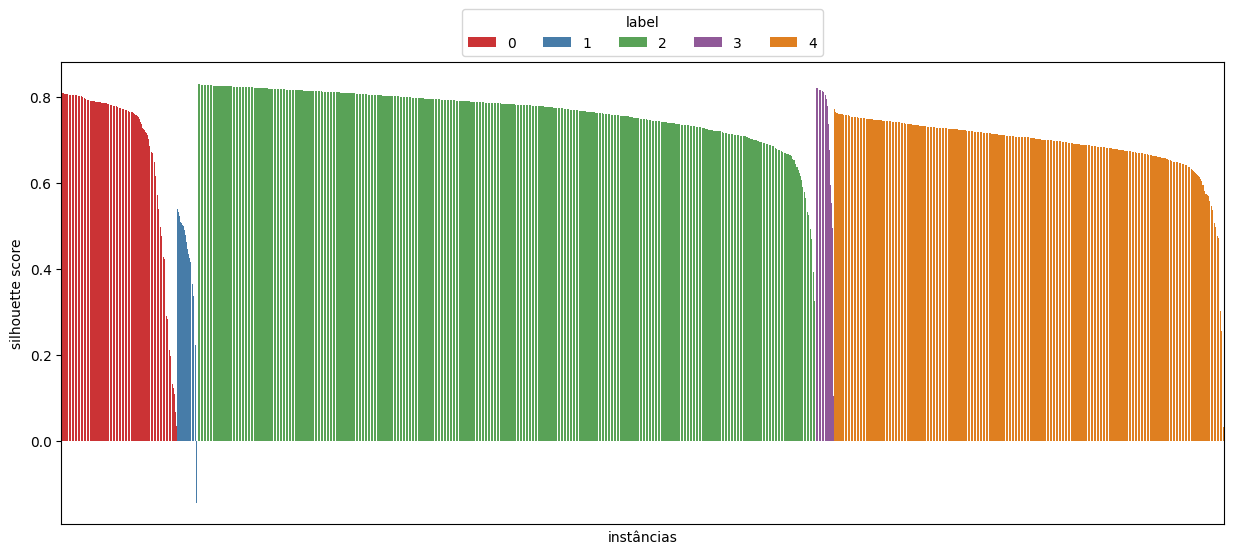

In [13]:
score_df = pd.DataFrame(dict(label=labels, score=sil_samples)).sort_values(["label", "score"], ascending=[True, False], ignore_index=True)
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.barplot(score_df, x=score_df.index, y="score", hue="label", errorbar=None, palette="Set1", ax=ax)

# Ajustes nos eixos e legenda
g.set(xticks=[], xlabel="instâncias", ylabel="silhouette score")
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 1), ncol=20)

plt.show()

**Características de clusters bem formados:**
- **Largura uniforme**: valores de silhouette consistentemente altos (próximos a 1)
- **Poucos valores negativos**: ausência ou mínima presença de pontos mal classificados
- **Espessura proporcional**: tamanhos de clusters balanceados quando apropriado
- **Valores acima da média global**: a maioria dos pontos do cluster supera o score médio

**Sinais de problemas na clusterização:**
- **Clusters "finos"**: valores de silhouette baixos indicando sobreposição
- **Muitos valores negativos**: pontos que estariam melhor em outros clusters
- **Assimetria extrema**: clusters muito desbalanceados em tamanho
- **Valores consistentemente abaixo da média**: clusters de baixa qualidade

Nos resultados obtidos, temos um resultado satisfatório, considerando as características desejáveis e não desejáveis listadas acima.

Uma outra forma típica de visualizar o resultado é reduzindo a dimensionalidade do dataset para 2 dimensões e plotando os clusters em um gráfico XY. A interpretação se dá de forma mais intuitiva, onde é possível identificar pontos aglomerados ou separados do seu conjunto:

ℹ️ Dimensões de X após PCA: (2722, 2)


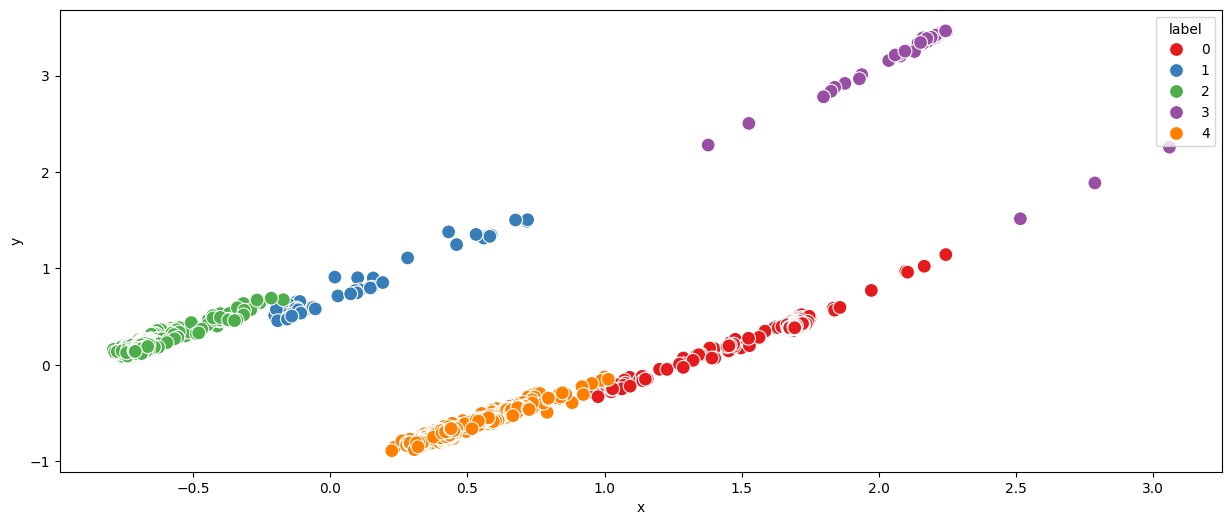

In [14]:
pca_2d = Pipeline([
    ("pre", preprocessor),
    ("model", PCA(n_components=2, random_state=SEED)),
])
X_2d = pca_2d.fit_transform(X)
print("ℹ️ Dimensões de X após PCA:", X_2d.shape)

clusters_df = pd.DataFrame(dict(x=X_2d[:, 0], y=X_2d[:, 1], label=labels)).sort_values("label", ignore_index=True)
fig, ax = plt.subplots(figsize=(15, 6))
g = sns.scatterplot(clusters_df, x="x", y="y", hue="label", s=100, palette="Set1", ax=ax)

plt.show()

Apesar de alguns overlaps, os conjuntos parecem bem definidos. No entanto, com a redução de dimensionalidade, perdem-se informações que podem comprometer um pouco a interpretação e avaliação da qualidade dos clusters.

Por último, no caso específico do nosso problema, por existir uma variável temporal, podemos ver como os grupos ficaram aglomerados nessa dimensão:

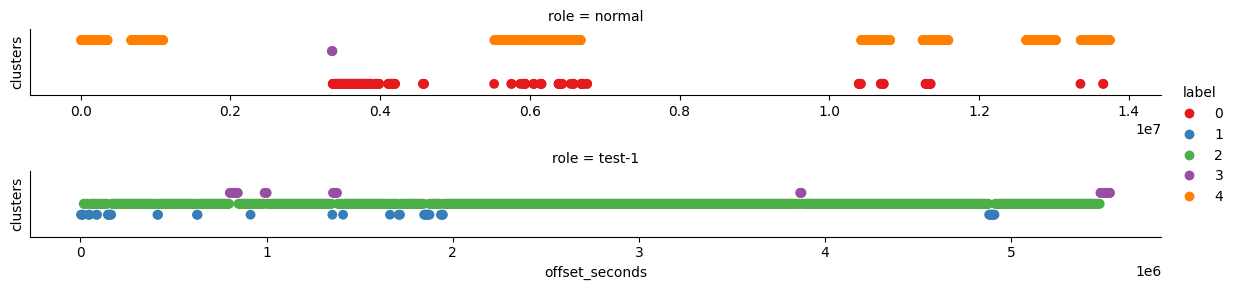

In [15]:
timeline_df = pd.DataFrame(dict(role=df["role"], offset_seconds=df["offset_seconds"], label=labels)).sort_values(["role", "offset_seconds"], ignore_index=True)

# fig, ax = plt.subplots(2, figsize=(20, 6))
# g = sns.pointplot(timeline_df, x="offset_seconds", y="label", hue="role", linestyle="none", palette="husl", ax=ax)
g = sns.relplot(timeline_df, x="offset_seconds", y="label", hue="label", row="role", kind="scatter", marker="o", s=50, alpha=1, linewidth=0, palette="Set1", height=1.5, aspect=8, facet_kws=dict(sharex=False))

# Ajustes nos eixos e legenda
g.set(ylim=(labels.min()-1, labels.max()+1), yticks=[], ylabel="clusters")
# plt.xticks(rotation=90)

plt.show()

De uma forma geral, com exceção dos clusters 1 e 3, os agrupamentos tendem a ter segmentos contínuos no tempo, com algumas poucas separações. Isso condiz com a realidade do problema em questão: perfis operacionais de um equipamento industrial (Turbina a Gás). Interessante notar que justamente os clusters 1 e 3 também apresentaram uma qualidade inferior no gráfico Silhouette Samples, o que denota consistência da análise.

# **Conclusão**

O problema de clusterização abordado nesse estudo é uma primeira etapa de uma análise mais abrangente da condição do equipamento (Turbina a Gás). A modelagem busca encontrar os agrupamentos de maior qualidade/mais nítidos para o dataset específico, que representem os diferentes perfis operacionais do equipamento. Essa clusterização ajudará na identificação e rotulação dos perfis operacionais pelos experts do domínio, sendo esta uma etapa inicial muito importante para futuras aplicações de modelos, como detecção de anomalias, em que é importante balancearmos os dados correspondentes à cada perfil operacional distinto.

O estudo contemplou a escolha da métrica mais adequada para o problema e as otimizações de hiperparâmetros, resultando numa clusterização satisfatória para objetivos futuros, conforme citado. No caso de novos datasets, um novo treinamento deverá ser realizado com os novos dados, visto que o modelo é mais apropriado para clusterizar o dataset no qual ele foi treinado, mas podendo-se utilizar o mesmo tipo de modelo e técnica aqui definidos. O objetivo final é embarcar essa técnica em uma ferramenta de análise de equipamentos, em que o usuário (expert do domínio) contará com ferramentas que o auxiliará na preparação dos dados, treinamento e colocação do modelo em produção.